# 3.4: Clustering

**Runtime: ~4 mins**

*In this part, clustering methods are tested on both datasets and interesting visualisations are shown. A comparison between clustering and classification algortihm is made.* \
*Lines **longer than 80** characters are continued on a new line.*

## Importing required libraries & modules
*Modules required for this task are impored below.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from ipynb.fs.defs.task3_1 import load_dataset, encode_dataset, simple_imputer,\
    iterative_imputer, scale_data, select_best_features
from ipynb.fs.defs.task3_2 import split_dataset
from sklearn.metrics import silhouette_score, silhouette_samples

*Datasets are loaded and pre-processed using functions from Task 3.1*

In [2]:
def pre_process_dataset(name: str, features_count: int,\
                        categorical_data: bool=False) -> np.ndarray:
    """
    Function that returns the pre-processed dataset using functions
    from task3_1.ipynb that import, encode, replaces missing values
    and selects best features from it.
    
    Args:
        name (str): The name of the dataset to import
        features_count (int): The number of features to select from 
            the dataset
        categorical_data (bool): If only categories should be imputed
            using Simple Imputer
    
    Returns:
        np.ndarray: The pre-processed dataset
    """
    
    dataset = load_dataset(name)
    encoded_set_info = encode_dataset(dataset, 'one-hot-encoder')
    encoded_dataset = encoded_set_info[0]
    imputed_dataset = iterative_imputer(simple_imputer(encoded_dataset,\
                                encoded_set_info[1], only_categories=True))
    scalled_dataset = scale_data(imputed_dataset, 'min-max')
    best_features_dataset = select_best_features(scalled_dataset, features_count,\
                                                 categorical_data)
    
    return best_features_dataset

In [3]:
# Assign pre-processed datasets
if __name__ == "__main__":
    stars_dataset = pre_process_dataset('star_assessment.csv', 12, categorical_data=True)
    gwp_dataset = pre_process_dataset('gwp_assessment.csv', 5)

In [4]:
# Split datasets
if __name__ == "__main__":
    x_train_stars, x_test_stars, y_train_stars, y_test_stars = split_dataset(stars_dataset, 0.2)
    x_train_gwp, x_test_gwp, y_train_gwp, y_test_gwp = split_dataset(gwp_dataset)

## Clustering for the GWP dataset
Since the GWP dataset is a regression problem meaning that it does not have classes in which the data can be classified, I will first use **different number of clusters** to get an idea of the right number of clusters to use, which will be the one that returns the highest accuracy.

### Create a function for KMeans clustering
*The function will be able to run the clustering method using either **KMeans**, or its improved version for large datasets - **MiniBatchKMeans**, for any number of clusters and return appropriate statistics.*

In [5]:
def KMeans_cluster(x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, \
    y_test: np.ndarray, clusters: int, type: str='KM') -> (int, np.ndarray):
    
    """
    Function that will create N clusters using
    the KMeans cluster method.
    
    Args:
        x_train (np.ndarray): X training data
        x_test (np.ndarray): X testing data
        y_train (np.ndarray): Y training data
        y_test (np.ndarray): Y testing data
        clusters (int): The number of clusters
        type (str): Type of KMeans cluster to be used
    
    Returns:
        int: The accuracy score of the cluster
        np.ndarray: Cluster labels' metric
    """
    
    # Cluster algorithm
    if type == 'KM':
        km = KMeans(n_clusters=clusters, n_init=10)
    else:
        km = MiniBatchKMeans(n_clusters=clusters, batch_size=clusters, n_init=3)
    km.fit(x_train)
    
    # Compute the performance of classification
    cluster_assoc = -1 * np.ones(clusters)
    for i, cls in enumerate(np.arange(clusters)):
        cluster_sample_cls = y_train[km.labels_ == cls]
        cls_in_cluster, cls_count = np.unique(cluster_sample_cls,\
                                              return_counts=True)
        cluster_assoc[i] = cls_in_cluster[np.argmax(cls_count)]
    
    # Compute score
    score = np.sum(cluster_assoc[km.predict(x_test)] == y_test) / y_test.size
    
    return round(score, 2), km.labels_

### Try different number of clusters for the GWP dataset

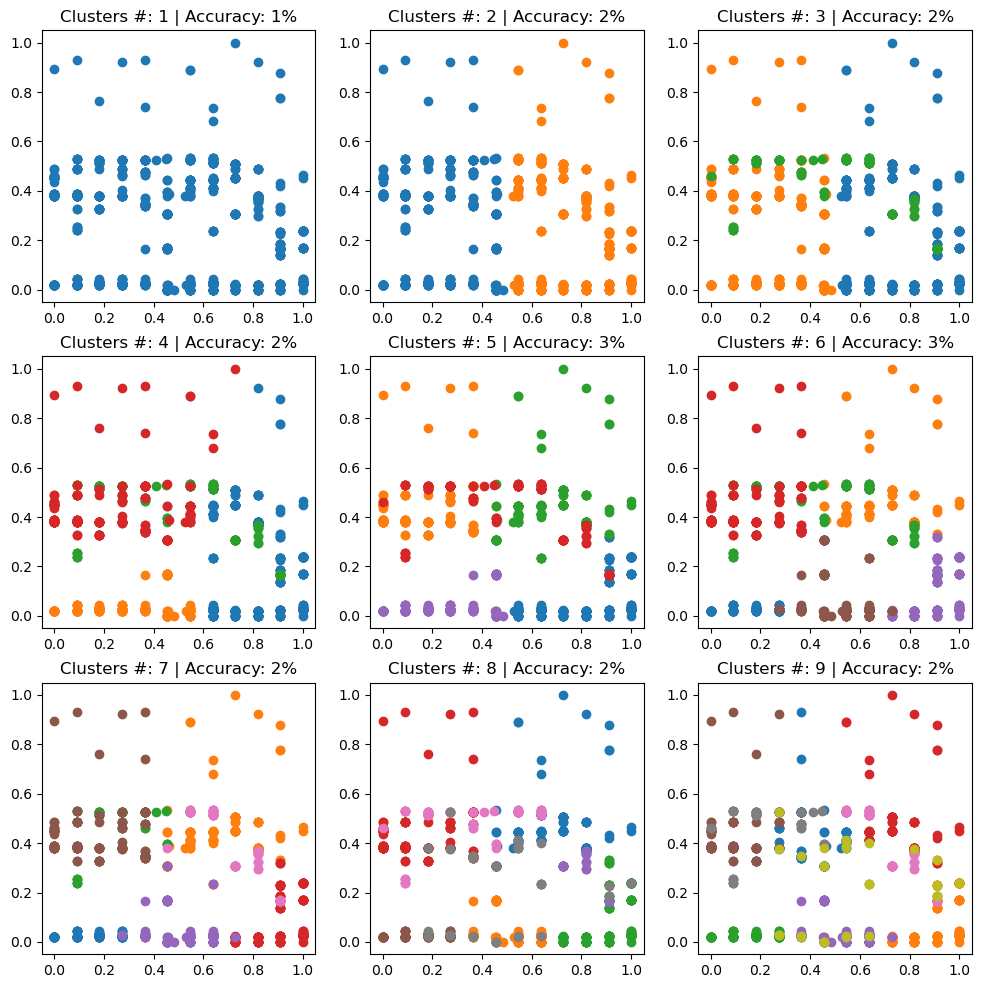

In [17]:
# Define plot size
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
subplot_positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2),\
                    (2, 0), (2, 1), (2, 2)]

for clusters, pos in enumerate(subplot_positions):
    # Compute statistics for the given number of clusters
    score, cls_labels = KMeans_cluster(x_train_gwp, x_test_gwp,\
                                y_train_gwp, y_test_gwp, clusters+1)

    # Plot statistics
    for i in range(clusters+1):
        axes[pos].plot(x_train_gwp[cls_labels == i, 0], x_train_gwp[cls_labels == i, 2], 'o')
    axes[pos].set_title('Clusters #: {0} | Accuracy: {1}%'.format(clusters+1,int(score * 100)))   
plt.show()

According to the graphs above, using more than 5 clusters does not have a major difference in how clusters are grouped and does not improve the score. I will therefore use 5 clusters to further visualise that method on the GWP dataset.

### How different features are grouped using *5* clusters on the GWP dataset

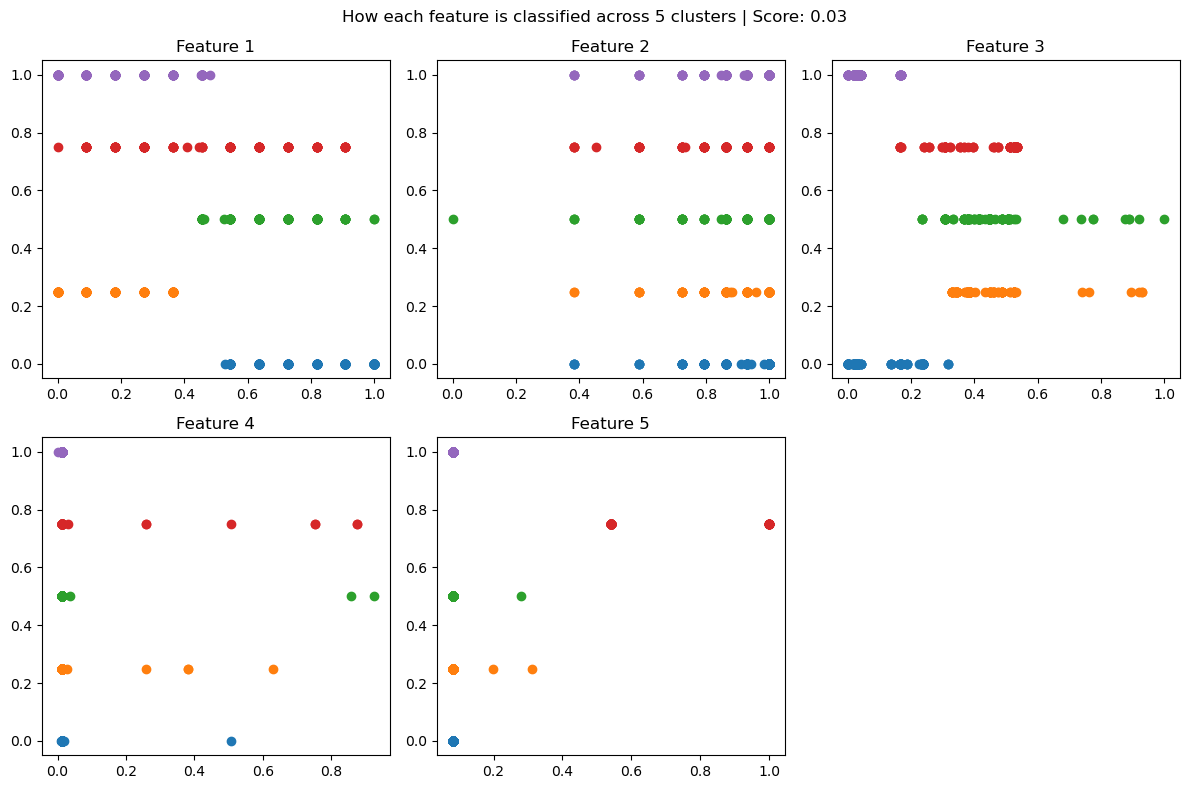

In [19]:
# Run the KMeans clustering method using 5 clusters
score, cls_labels = KMeans_cluster(x_train_gwp, x_test_gwp,\
                            y_train_gwp, y_test_gwp, 5)

# Setup the plots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
subplot_positions_5 = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)]

# Plot the points
for f, pos in enumerate(subplot_positions_5):
    for i in range(clusters):
        axes[pos].plot(x_train_gwp[cls_labels == i, f], \
            np.full_like(x_train_gwp[cls_labels == i, f], i * 0.25), 'o')
        axes[pos].set_title('Feature {0}'.format(f+1))
        
axes[1, 2].axis('off')
plt.suptitle('How each feature is classified across 5 clusters | Score: ' + str(score))
plt.tight_layout()
plt.show()

In conclusion, using 5 clusters on the GWP dataset seems to group data points good, however accuracy for that method is very low indicating that using clustering for regression problems is not a good approach; and rather a combination of clustering and regression methods should be used instead.

## Clustering for the Stars dataset
Since the Stars dataset is huge, instead of using **KMeans**, I will use **MiniBatchKMeans** which proves efficient in large datasets. Further, I will reduce the number of samples used for the clustering, in order to increase the processing time while still allowing the method to provide me with meaningful insights; Only 5% of the sample data will be used. The number of clusters is 3 and unlike with the GWP dataset is fixed as there are 3 classes to which data points can be classified.

Text(0.5, 1.0, 'Stars dataset using 3 clusters | Score: 0.6')

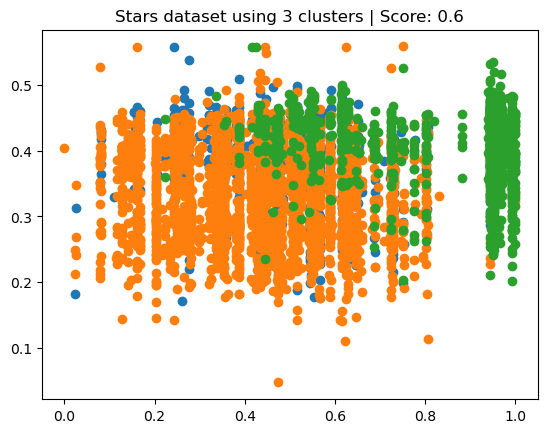

In [8]:
xtr, xte, ytr, yte = x_train_stars[:5000, :], x_test_stars[:5000, :],\
    y_train_stars[:5000], y_test_stars[:5000]

# Get metrics for MiniBatchKMeans method on the Stars datase
score, cls_labels = KMeans_cluster(xtr, xte, ytr, yte, 3, 'MBKM')

# Plot statistics
for i in range(3):
    plt.plot(xtr[cls_labels == i, 0], \
             xtr[cls_labels == i, 2], 'o')
plt.title('Stars dataset using 3 clusters | Score: ' + str(score))

### How different features are grouped using 3 clusters on the Stars dataset
Using ***all*** the data points in the dataset to show how each feature is classified.

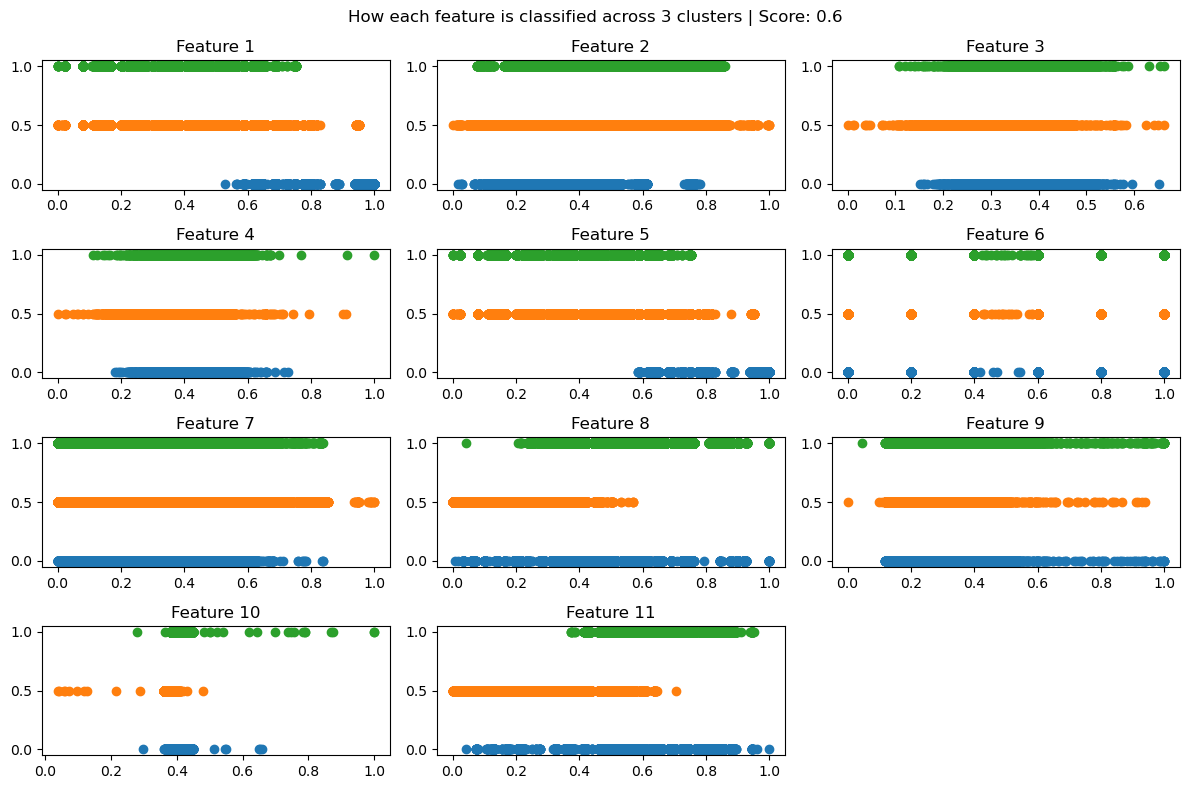

In [9]:
# Run the MiniBatchKMeans clustering method using 3 clusters
score_stars, cls_labels_stars = KMeans_cluster(x_train_stars, x_test_stars,\
                            y_train_stars, y_test_stars, 3, 'MBKM')

# Setup the plots
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
subplot_positions_stars = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2),\
                      (2, 0), (2, 1), (2, 2), (3, 0), (3, 1)]

# Plot the points
for f, pos in enumerate(subplot_positions_stars):
    for i in range(3):
        axes[pos].plot(x_train_stars[cls_labels_stars == i, f],\
            np.full_like(x_train_stars[cls_labels_stars == i, f], i * 0.5), 'o')
        axes[pos].set_title('Feature {0}'.format(f+1))
        
axes[3, 2].axis('off')
plt.suptitle('How each feature is classified across 3 clusters | Score: ' + \
            str(score_stars))
plt.tight_layout()
plt.show()

### Silhouette Coefficient of all samples from Stars dataset
*Calculating Silhouette Coefficient on **all** samples from the MiniBatchKMeans clustering, where value closer to 1 means that values have been classified correctly; close to 0 indicate overlapping clusters, and negative score indicate that a sample has been assigned to the wrong cluster.*

In [10]:
silhouette_score(x_train_stars, cls_labels_stars, metric='euclidean')

0.2170148802833561

With positive score, closer to 0 than 1, I conclude that clustering proves to be working, however still not sufficient for classifying values to the accepted standard.

### Silhouette Coefficient of each feature from the Stars dataset
I will now calculate the Silhouette Coefficient for **individual** features using only 25% of the dataset to reduce computation times, but sufficient for the score to be computed:

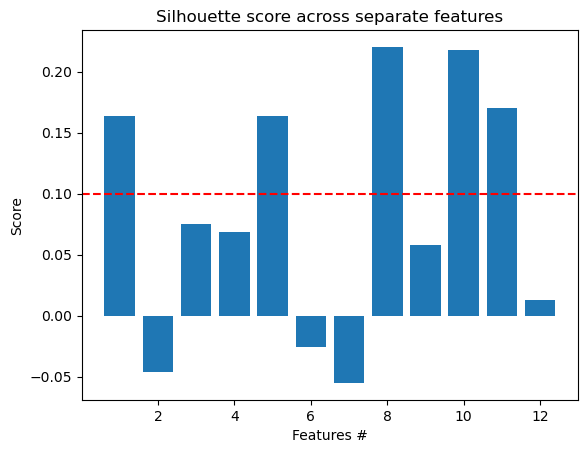

In [11]:
# Compute the Silhouette Coefficient for each feature
values = []
for i in range(x_train_stars.shape[1]):
    feature_x_train = x_train_stars[:20000, i]
    values.append(silhouette_score(feature_x_train.reshape(-1, 1),\
        cls_labels_stars[:20000], metric='euclidean'))

# Visualise statistics
plt.bar(range(1,len(values)+1), values)
plt.axhline(y=0.1, color='r', linestyle='dashed')
plt.xlabel('Features #')
plt.ylabel('Score')
plt.title('Silhouette score across separate features')
plt.show()

From the diagram it is noticeable that some features have a high score (> 0.1) indicating that samples from that feature are classified correctly, whereas other features have low (<= 0.1) or negative score indicating that the samples from those features are probably classified wrong.

### Silhouette Coefficient individually for the first 10k samples from Stars dataset
I will now visualise the Silhouette score **individually** for the first 10000 **samples** of the Stars dataset:

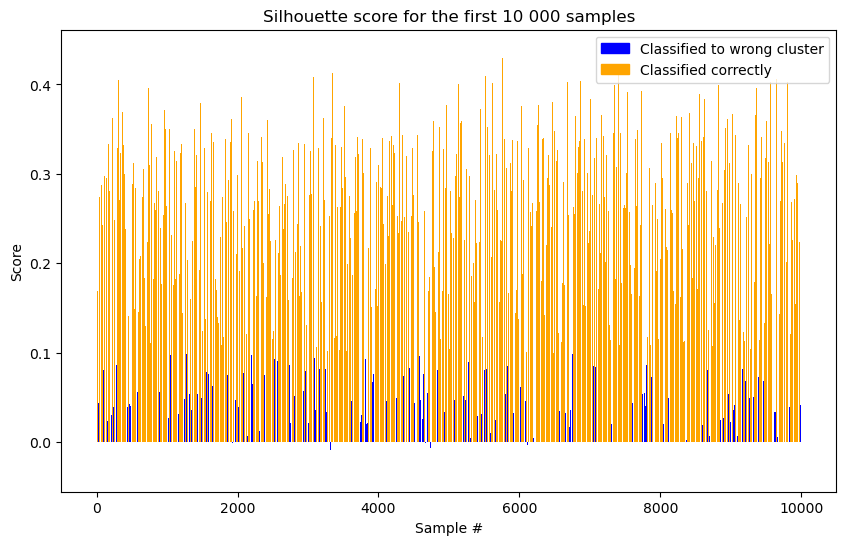

In [12]:
# Compute the Silhouette Coefficient for the first 10k samples
scores = silhouette_samples(x_train_stars[:10000, :], cls_labels_stars[:10000])

# Visualise statistics
conditions = [
    scores < 0.10,
    scores >= 0.10
]
choices = ['blue', 'orange']
colors = np.select(conditions, choices)

fig = plt.figure(figsize=(10, 6))
plt.bar(range(scores.size), scores, color=colors)
plt.xlabel('Sample #')
plt.ylabel('Score')
plt.title('Silhouette score for the first 10 000 samples')
blue_patch = mpatches.Patch(color='blue', label='Classified to wrong cluster')
orange_path = mpatches.Patch(color='orange', label='Classified correctly')
plt.legend(handles=[blue_patch, orange_path], loc='upper right')
plt.show()

From the results I observe that most samples get classified to the correct cluster (indicated by orange color). Although few of the samples are producing a weak score (indicated by blue color), only a small amount are negative values meaning they actually get classified to the wrong cluster.\
To find exactly how many values are considered to be correctly classified:

In [20]:
correct = np.where(colors == 'orange')[0].size

print('{0} samples correctly classified [{1}% of the data]'.format(correct,\
                                            (correct / 10000) * 100))
print('{0} samples incorrectly classified [{1}% of the data]'.format(10000-correct,\
                                        (10000 - correct) / 10000 * 100))


8002 samples correctly classified [80.02% of the data]
1998 samples incorrectly classified [19.98% of the data]


### Another cluster method for Stars dataset
*I will now use **AgglomerativeClustering** for the Stars dataset to see if performance improves than using **KMeans** clustering. Once again I will only use 25% of the data to reduce computational times but still get sufficient results.*

Text(0.5, 1.0, 'Stars dataset using 3 clusters | Score: 0.5984')

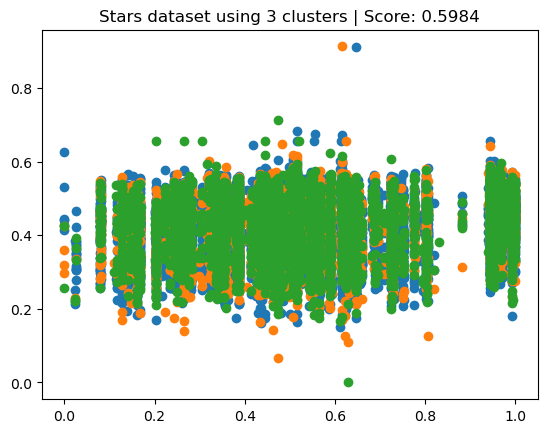

In [14]:
# Run AgglomerativeClustering and compute cluster labels and score
samples = 20000
ac = AgglomerativeClustering(n_clusters=3)
pred = ac.fit_predict(stars_dataset[:samples, :])

# Compute the performance of classification
cluster_assoc = -1 * np.ones(clusters)
for i, cls in enumerate(np.arange(3)):
    cluster_sample_cls = y_train_stars[:samples][ac.labels_ == cls]
    cls_in_cluster, cls_count = np.unique(cluster_sample_cls,\
                                          return_counts=True)
    cluster_assoc[i] = cls_in_cluster[np.argmax(cls_count)]
        
# Compute score
score = np.sum(cluster_assoc[pred] == y_test_stars[:samples]) / y_test_stars[:samples].size

# Visualise data
xtr = x_train_stars[:samples, :]
for i in range(3):
    plt.plot(xtr[ac.labels_ == i, 0], \
             xtr[ac.labels_ == i, 3], 'o')
plt.title('Stars dataset using 3 clusters | Score: ' + str(score))

The resulted graph indicates that the cluster method successfully classifies data points with about 60% accuracy, which is similar to using KMeans clustering and therefore justifying that **both** clustering algorithms are suitable for the Stars dataset.